<a href="https://colab.research.google.com/github/coitloz88/Reinforcement-learning-Practice/blob/master/08_implement_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN 구현
카트를 잘 밀어서 막대가 넘어지지 않도록 균형을 잡는 CartPole이라는 문제를 풀어보자.

카트는 일정한 힘으로 왼쪽이나 오른쪽으로 밀 수 있기 때문에 선택 가능한 액션은 항상 2가지이고, 스텝마다 +1의 보상을 받으므로 보상을 최적화하는 것은 곧 막대를 넘어뜨리지 않고 가능한 오래도록 균형을 잡는 것이다.

카트의 상태 $s$는 길이 4의 벡터로, 다음과 같다.
<center>
    $s = (카트의\,위치,\,카트의\,속도,\,막대의\,속도,\,막대의\,각속도)$
</center>

## 라이브러리 import
`collections` 라이브러리 안의 deque라는 자료구조를 통해 선입 선출(first-in-first-out)의 특성을 갖는 리플레이 버퍼를 쉽게 구현 가능하다.

In [1]:
import gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 하이퍼 파라미터 정의

In [2]:
# Hyperparameters
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000
batch_size = 32

## 리플레이 버퍼 클래스

최신 5만개의 데이터를 가지고 있다가 필요할 때마다 `batch_size`만큼의 데이터를 뽑아서 제공해준다.

`put` 함수는 데이터를 버퍼에 넣어주는 역할을 수행하며, `sample` 함수는 버퍼에서 랜덤하게 32개의 데이터를 뽑아 mini-batch를 구성한다.

32개의 데이터를 뽑고 나면 각 요소 별로 모아 pytorch의 텐서로 변환해준다.





In [3]:
class ReplayBuffer():
  def __init__(self):
      self.buffer = collections.deque(maxlen = buffer_limit)

  def put(self, transition):
    self.buffer.append(transition)

  def sample(self, n):
    mini_batch = random.sample(self.buffer, n)
    s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
    
    for transition in mini_batch:
      s, a, r, s_prime, done_mask = transition
      s_lst.append(s)
      a_lst.append([a])
      r_lst.append([r])
      s_prime_lst.append(s_prime)
      done_mask_lst.append([done_mask])

    return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
            torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
            torch.tensor(done_mask_lst)
            
  def size(self):
    return len(self.buffer)

## Q밸류 네트워크
사용될 뉴럴넷의 구조는 다음과 같다.  
<center>

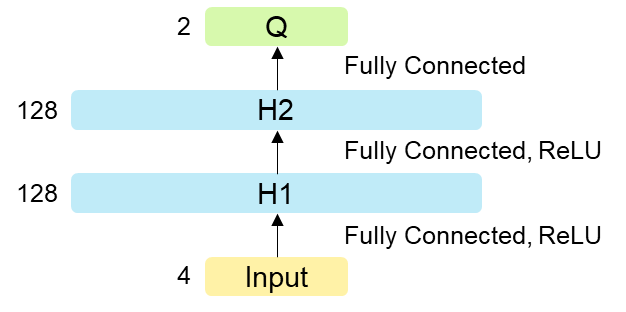

</center>

In [4]:
class Qnet(nn.Module):
  def __init__(self):
    super(Qnet, self).__init__()
    self.fc1 = nn.Linear(4, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def sample_action(self, obs, epsilon):
    out = self.forward(obs)
    coin = random.random()
    if coin < epsilon:
      return random.randint(0, 1)
    else:
      return out.argmax().item()

## 학습 함수
에피소드 하나가 끝날 때마다 본 함수가 호출되며, 한 번 호출될 때마다 10개의 mini-batch를 뽑아 총 10번 업데이트한다.
각각의 for-loop 안에서는 먼저 리플레이 버퍼에서 mini-batch를 뽑고 해당 데이터를 이용하여 loss를 계산한다. loss가 계산되고 나면 `loss.backward()`를 호출하여 실제 그래디언트를 계산한다. 이후 `optimizer.step()`을 실행하면 Qnet의 파라미터 업데이트가 일어난다.

In [5]:
def train(q, q_target, memory, optimizer):
  for i in range(10):
    s, a, r, s_prime, done_mask = memory.sample(batch_size)

    q_out = q(s)
    q_a = q_out.gather(1, a)
    max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
    target = r + gamma * max_q_prime * done_mask
    loss = F.smooth_l1_loss(q_a, target)

    optimizer.zero_grad()
    loss.backward() # loss에 대한 그래디언트를 계산함
    optimizer.step()

## Main 함수

In [6]:
def main():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(10000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break
            
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode: {}, score: {:.1f}, n_buffer: {}, eps: {:.1f}%".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon*100))
            score = 0.0
    env.close()

In [7]:
main()

n_episode: 20, score: 10.7, n_buffer: 213, eps: 7.9%
n_episode: 40, score: 9.7, n_buffer: 407, eps: 7.8%
n_episode: 60, score: 9.4, n_buffer: 596, eps: 7.7%
n_episode: 80, score: 9.4, n_buffer: 784, eps: 7.6%
n_episode: 100, score: 9.2, n_buffer: 967, eps: 7.5%
n_episode: 120, score: 10.2, n_buffer: 1172, eps: 7.4%
n_episode: 140, score: 9.6, n_buffer: 1364, eps: 7.3%
n_episode: 160, score: 9.4, n_buffer: 1552, eps: 7.2%
n_episode: 180, score: 9.8, n_buffer: 1747, eps: 7.1%
n_episode: 200, score: 9.4, n_buffer: 1935, eps: 7.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


n_episode: 220, score: 9.9, n_buffer: 2133, eps: 6.9%
n_episode: 240, score: 10.2, n_buffer: 2336, eps: 6.8%
n_episode: 260, score: 11.2, n_buffer: 2560, eps: 6.7%
n_episode: 280, score: 12.3, n_buffer: 2806, eps: 6.6%
n_episode: 300, score: 13.6, n_buffer: 3077, eps: 6.5%
n_episode: 320, score: 25.4, n_buffer: 3584, eps: 6.4%
n_episode: 340, score: 81.9, n_buffer: 5222, eps: 6.3%
n_episode: 360, score: 85.1, n_buffer: 6924, eps: 6.2%
n_episode: 380, score: 144.2, n_buffer: 9807, eps: 6.1%
n_episode: 400, score: 163.4, n_buffer: 13075, eps: 6.0%
n_episode: 420, score: 222.6, n_buffer: 17526, eps: 5.9%
n_episode: 440, score: 220.2, n_buffer: 21931, eps: 5.8%
n_episode: 460, score: 237.6, n_buffer: 26683, eps: 5.7%
n_episode: 480, score: 104.0, n_buffer: 28763, eps: 5.6%
n_episode: 500, score: 73.5, n_buffer: 30234, eps: 5.5%
n_episode: 520, score: 111.0, n_buffer: 32453, eps: 5.4%
n_episode: 540, score: 138.8, n_buffer: 35230, eps: 5.3%
n_episode: 560, score: 201.3, n_buffer: 39256, eps

KeyboardInterrupt: ignored